# Zajęcia 6: Sprawozdanie z prac badawczych

## Spis Treści:
* Rozdział 0 ------------------------------------------ Wprowadzenie  
* Rozdział 1 ------------------------------------------ Obsługa danych i podstawy implementacji obliczeń
* Rozdział 2 ------------------------------------------ Dopasowanie modelu do danych rzeczywistych
* Rozdział 3 ------------------------------------------ Dopasowanie rozkładu do danych
* Rozdział 4 ------------------------------------------ Zastosowanie optymalizatora do dopasowania modelu/rozkladu do danych rzeczywistych
* Rozdział 5 ------------------------------------------ Podsumowanie

## Rozdział 0: Wprowadzenie

Praca na zbiorach danych jest ciężka i żmudna, a gdy tabela ma kilka tysięcy wierszy to ręczne robienie statystyk staje się praktycznie niemożliwe. Na szczęście z pomocą przychodzą nam biblioteki języka Python, które robią bardzo skomplikowane operacje w zaledwie kilka milisekund. To sprawozdanie przedstawia wszystkie podstawowe oraz zaawansowane techniki opracowania danych. Podzieliłem je na 4 zadania, są to w kolejności odpowiednio: podstawy obsługi danych i obliczeń, utworzenie oraz dopasowanie modelu do danych, dopasowanie rozkładu do danych, zastosowanie optymalizatora. Przejdźmy zatem do pierwszego z nich, czyli do podstawowych operacji na zbiorach danych.

### 1. Obsługa danych i podstawy implementacji obliczeń

Zacznijmy od czegoś prostego, wybierzmy dowolny plik z internetu, odczytajmy go i zapiszmy jako tabelę w programie. Możemy to zrobić najprościej używając biblioteki pandas. Pobrałem plik z Wikipedii przedstawiający dane oraz statystyki rzek przepływających przez Białoruś. Pokażmy tabelę na ekranie.

In [14]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

URL = "https://en.wikipedia.org/wiki/List_of_rivers_of_Belarus"
resp = requests.get(URL) 
if resp.status_code == 200:
    soup = BeautifulSoup(resp.content,'html.parser')
    tab = soup.find('table',{'class':"wikitable"})
df = pd.read_html(str(tab))[0]
df


,Name,"Total, km","In Belarus, km"
0,Dnieper River,2145,690
1,Western Dvina,1020,328
2,Neman River,937,459
3,Bug River,831,169
4,Pripyat River,761,495
5,Sozh River,648,493
6,Berezina River,613,613
7,Vilija,510,276
8,Ptsich,421,421
9,Shchara,325,325


Zanim przedstawimy te dane na wykresie uporządkujmy je. Utwórzym trzy zbiory danych, niech będą to:
* names - nazwy rzek
* X - całkowita długość rzek
* Y - długość rzek w kraju

In [15]:
names = df['Name'].values
X = df['Total, km'].values
Y = df['In Belarus, km'].values

print('Zbiór names - Nazwy rzek: \t\t\t\t\t\t\t\t\t\t (1)')
for n in names:
    print('\t' + '* ' + n)
print('Zbiór X - Długości całkowite rzek: %s \t\t (2)' % X)
print('Zbiór Y - Długości rzek w kraju:   %s \t\t\t (3)' % Y)


Zbiór names - Nazwy rzek: 										 (1)
	* Dnieper River
	* Western Dvina
	* Neman River
	* Bug River
	* Pripyat River
	* Sozh River
	* Berezina River
	* Vilija
	* Ptsich
	* Shchara
	* Svislach
Zbiór X - Długości całkowite rzek: [2145 1020  937  831  761  648  613  510  421  325  297] 		 (2)
Zbiór Y - Długości rzek w kraju:   [690 328 459 169 495 493 613 276 421 325 297] 			 (3)


Przedstawmy powyższe dane na wykresie. Najlepszym do tego celu będzie wykres kolumnowy, który na osi x będzie zawierał nazwy rzek, natomiast na osi y stosunek długości danej rzeki w kraju do jej długości całkowitej w procentach.

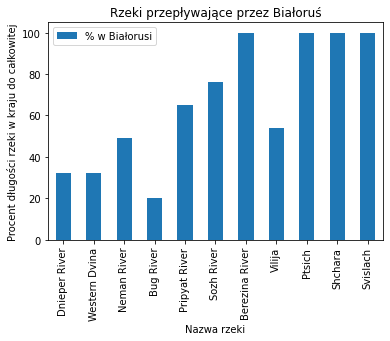

In [16]:
import matplotlib.pyplot as plt

df['% w Białorusi'] = df['In Belarus, km'] / df['Total, km'] * 100

riversPlot = df.plot(x='Name', y='% w Białorusi', kind='bar', title='Rzeki przepływające przez Białoruś')
plt.xticks(rotation=90)
riversPlot.set_xlabel('Nazwa rzeki')
riversPlot.set_ylabel('Procent długości rzeki w kraju do całkowitej')
plt.show()


Mając taki wykres łatwo można stwierdzić, które rzeki mają ponad 50% swojej długości w kraju. Nie potrzeba dużej modyfikacji by to zwizualizować.

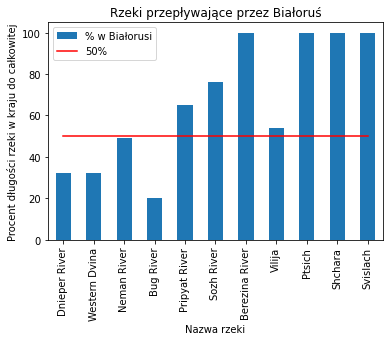

In [17]:
line50 = []
dataSize = df['% w Białorusi'].size
PERCENT50 = 50

for i in range(0, dataSize):
    line50.append(PERCENT50)

ax = df.plot(x = "Name", y = "% w Białorusi", kind = "bar", title = "Rzeki przepływające przez Białoruś")
ax.set_xlabel('Nazwa rzeki')
ax.set_ylabel('Procent długości rzeki w kraju do całkowitej')

bx = pd.DataFrame(line50, columns = ['50%'])
bx.plot(ax=ax, color='#FF0000')
plt.xticks(ax.get_xticks(), rotation = 90)
plt.show()


Skoro podstawy mamy opanowane, przejdźmy do bardziej zaawansowanych zagadnień, zajmujmy się dopasowaniem modelu do powyższych danych.

### 2. Dopasowanie modelu do danych rzeczywistych

Żeby pracować na modelu należy najpierw go utworzyć, do tego będą nam potrzebne zdefiniowane wyżej zbiory (2) i (3). Model odpowie nam na pytanie czy istnieje jakaś zależność między tymi danymi.

Zanim przejdziemy do budowy modelu zobaczmy jak nasze dane wyglądają na wykresie punktowym.

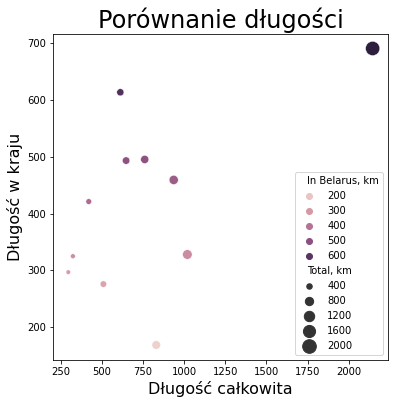

In [18]:
import seaborn as sns

plt.figure(figsize=(6,6))
sns.scatterplot(
    x = 'Total, km',
    y = 'In Belarus, km',
    data = df,
    hue = 'In Belarus, km',
    size = 'Total, km',
    sizes = (20, 200),
    legend = 'brief'
)
plt.xlabel("Długość całkowita", size=16)
plt.ylabel("Długość w kraju", size=16)
plt.title("Porównanie długości", size=24)
plt.show()


W tym zadaniu skupimy się na dwóch metodach wyznaczenia modelu liniowego. Będą to metoda prób i błędów oraz analityczna. Do obliczeń zastosujemy metodę najmniejszych kwadratów.

#### Metoda prób i błędów

 Metoda prób i błędów pozwala wyznaczyć przybliżony model liniowy. Nie jest on idealny, ponieważ jak widzimy błąd średniokwadratowy jest bardzo duży. Do policzenia błędu korzystam z następującego wzoru:

$$e_i=y_i-\overline{y_i}.$$

\begin{equation}
Q(a,b) = \frac{1}{N}\sum_{i=1}^Ne_i^2 \ ,
\tag{4}
\end{equation}

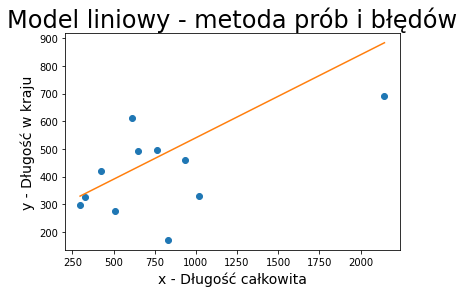

Parametr a wynosi: 		 0.3
Parametr b wynosi: 		 240
Błąd przybliżenia wynosi: 	 22653.47


In [19]:
def model (parametry, x):
    a, b = parametry
    return a * x + b

# dobieramy liczby tak żeby 'pasowało'
a_est, b_est = 0.3, 240

# liczymy błąd
def count_error(a_est, b_est):
    dataSize = X.size
    error = 0
    for i in range(0, dataSize):
        error = error + (Y[i] - model([a_est, b_est], X[i])) ** 2
    return error

# rysujemy wykres
X_test = np.linspace(start = X.min(), stop = X.max(), num = 300)
Y_pred = model(parametry = [a_est, b_est], x = X_test)

plt.scatter(X,Y)
plt.plot(X_test, Y_pred, color = 'tab:orange')
plt.xlabel('x - Długość całkowita', fontsize = 14)
plt.ylabel('y - Długość w kraju', fontsize = 14)
plt.title('Model liniowy - metoda prób i błędów', size = 24)
plt.show()

# wyświetlamy błąd
print('Parametr a wynosi: \t\t %s' % round(a_est, 4))
print('Parametr b wynosi: \t\t %s' % round(b_est,2))
print('Błąd przybliżenia wynosi: \t %s' % str(round(count_error(a_est, b_est) / dataSize, 2)) )


#### Metoda analityczna

Ta metoda jest skuteczniejsza, jednak nie aż tak jak metody biblioteczne języka python. Dlaczego? Ponieważ liczę tutaj po kolei każdy element sumy w pętli for, biblioteki pythona robią to znacznie efektywniej, dzięki czemu są szybsze i dokładniejsze. Wzory obliczające parametry a oraz b we wzorze na linię regresji y = ax + b dla metody najmniejszych kwadratów wyglądają następująco:

$$a = \frac{\left( \sum^{n}_{i = 1} x_i y_i \right) - n \cdot \overline{x} \cdot \overline{y}}{\left( \sum^{n}_{i = 1} x_{i}^2 \right) - n \cdot \overline{x}^2}$$

$$b = \overline{y} - a \cdot \overline{x}$$

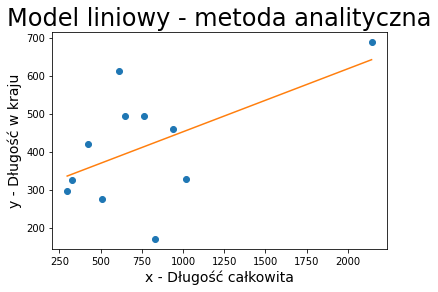

Parametr a estymowany metodą najmniejszych kwadratów wynosi: 	 0.1659
Parametr b estymowany metodą najmniejszych kwadratów wynosi: 	 286.75
Błąd przybliżenia wynosi: 					 15104.65


In [20]:
xAvr = X.mean()
yAvr = Y.mean()
DATASIZE = X.size

a_est = 0
b_est = 0

# liczymy a
# licznik
up = 1
for i in range(0, DATASIZE):
    up = up + (X[i] * Y[i])
up = up - (DATASIZE * xAvr * yAvr)

# mianownik
down = 1
for i in range(0, DATASIZE):
    down = down + (X[i] ** 2)
down = down - (DATASIZE * (xAvr ** 2))

# wynik
a_est = up / down

# liczymy b
b_est = yAvr - (a_est * xAvr)

# rysujemy wykres
X_test = np.linspace(start = X.min(), stop = X.max(), num = 300)
Y_pred = model(parametry = [a_est, b_est], x = X_test)

plt.scatter(X,Y)
plt.plot(X_test, Y_pred, color = 'tab:orange')
plt.xlabel('x - Długość całkowita', fontsize = 14)
plt.ylabel('y - Długość w kraju', fontsize = 14)
plt.title('Model liniowy - metoda analityczna', size = 24)
plt.show()

# wyświetlamy wyliczone wartości
print('Parametr a estymowany metodą najmniejszych kwadratów wynosi: \t %s' % round(a_est, 4))
print('Parametr b estymowany metodą najmniejszych kwadratów wynosi: \t %s' % round(b_est,2))
print('Błąd przybliżenia wynosi: \t\t\t\t\t %s' % str(round(count_error(a_est, b_est) / DATASIZE, 2)) )


Jak łatwo zauważyć metoda analityczna daje znacznie lepszy wynik od metody prób i błędów, ponieważ błąd jest dużo mniejszy.

#### Model i testy

Budowa oraz ćwiczenie modelu wymagają utowrzenia dodatkowych zbiorów testowych. Musimy zatem podzielić nasz zbiór (2) na zbiór treningowy: X_train oraz zbiór testowy X_test. Analogicznie postępujemy dla zbioru (3). Mamy na wykresie narysowane dwa modele: liniowy oraz uogólniony liniowy. Ponadto zaznaczone jest które rzeki zostały wzięte do treningu, a które do testów.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

def showPlot(percentTrain, percentTest):
    # =========  Model liniowy =========
    from sklearn.linear_model import LinearRegression
    model_lin = LinearRegression()
    model_lin.fit(X_train.reshape(-1,1), Y_train)
    print(f'Parametry modelu liniowego: {np.round(model_lin.coef_,4)}, {np.round(model_lin.intercept_,2)}')
    MSE_lin = mean_squared_error(Y_test, model_lin.predict(X_test.reshape(-1,1)))
    print('Błąd średniokwadratowy modelu liniowego: %s \n' % round(MSE_lin,2))

    # ===== Uogólniony model liniowy (ang. Generalized Linear Model) =====
    from sklearn.preprocessing import PolynomialFeatures
    model_GLM = LinearRegression()
    gen_features = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
    model_GLM.fit(gen_features.fit_transform(X_train.reshape(-1,1)), 
              Y_train)
    print(f'Parametry modelu GLM: {np.round(model_GLM.coef_,4)}, {np.round(model_GLM.intercept_,2)}')
    MSE_GLM = mean_squared_error(Y_test, model_GLM.predict(gen_features.fit_transform(X_test.reshape(-1,1))))
    print('Błąd średniokwadratowy modelu GLM: %s \n' % round(MSE_lin,2))

    # Predykcje wszystkich modeli dla całego zakreso osi X
    os_x = np.linspace(start=X.min(), stop=X.max(), num=300)
    y_lin_pred = model_lin.predict(os_x.reshape(-1,1))
    y_GLM_pred = model_GLM.predict(gen_features.fit_transform(os_x.reshape(-1,1)))

    # Wizualizacja
    plt.figure(figsize=(10,7))
    plt.scatter(X_train, Y_train, label='dane treningowe: %s' % str(percentTrain * 100), alpha=0.7)
    plt.scatter(X_test, Y_test, edgecolor='black', facecolor='none', label='dane testujące: %s' % str(percentTest * 100))
    plt.plot(os_x, y_lin_pred, label='model liniowy', color='tab:orange')
    plt.plot(os_x, y_GLM_pred, label=f'model GLM', color='tab:red')
    plt.xlabel('Długość całkowita', fontsize=14)
    plt.ylabel('Długość w kraju', fontsize=14)
    plt.title('Model liniowy - biblioteki Python', size=24)
    plt.legend(fontsize=12, shadow=True, loc='lower right')
    plt.ylim([Y.min()-0.1, Y.max()+0.5])
    plt.show()
    

##### Dane treningowe 80% : Dane testujące 20%

Parametry modelu liniowego: [0.1994], 281.34
Błąd średniokwadratowy modelu liniowego: 48580.21 

Parametry modelu GLM: [ 0.000e+00  3.919e-01 -1.000e-04], 204.93
Błąd średniokwadratowy modelu GLM: 48580.21 



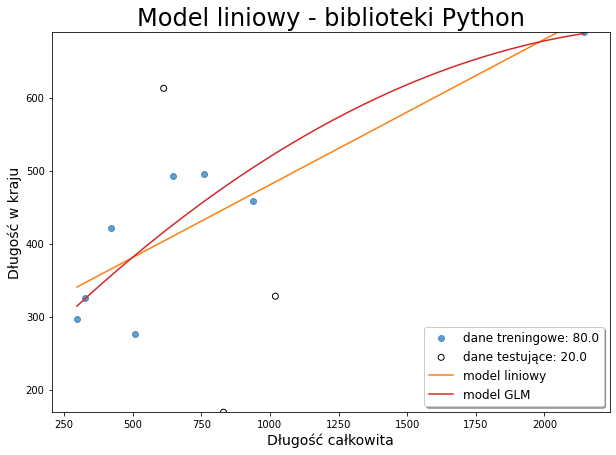

In [22]:
showPlot(0.8, 0.2)


Co by się stało gdybyśmy zwiększyli ilość danych do testów? Czy zmienił by się kształt któregoś z wykresów? Sprawdźmy to doświadczalnie: za pierwszym razem weźmy 30% danych do testów a za drugim 50%.

##### Dane treningowe 70% : Dane testujące 30%

Parametry modelu liniowego: [0.1634], 322.43
Błąd średniokwadratowy modelu liniowego: 26232.76 

Parametry modelu GLM: [0.     0.1483 0.    ], 328.34
Błąd średniokwadratowy modelu GLM: 26232.76 



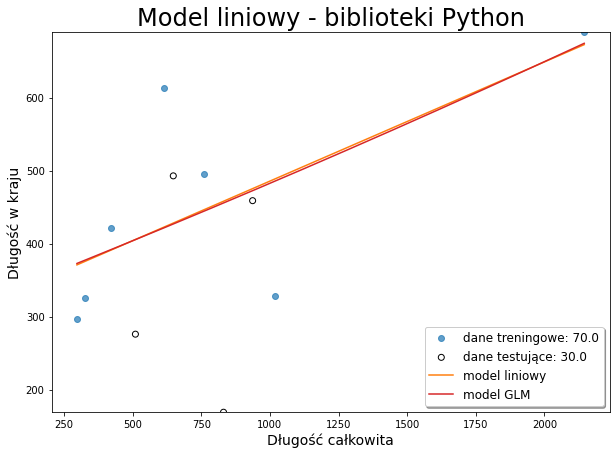

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
showPlot(0.7, 0.3)


#### Dane treningowe 50% : Dane testujące 50%

Parametry modelu liniowego: [0.2106], 251.89
Błąd średniokwadratowy modelu liniowego: 25489.84 

Parametry modelu GLM: [ 0.000e+00  4.135e-01 -1.000e-04], 166.79
Błąd średniokwadratowy modelu GLM: 25489.84 



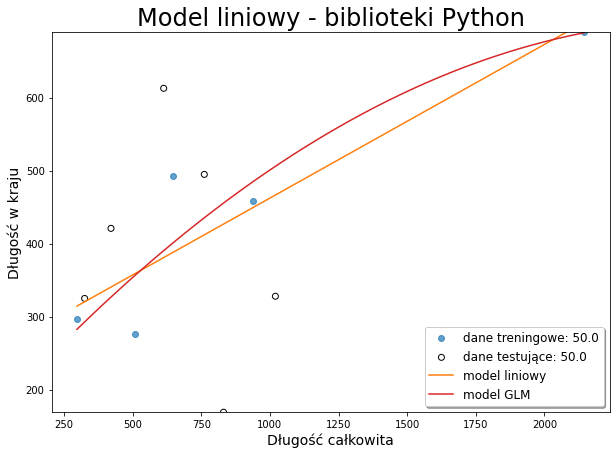

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)
showPlot(0.5, 0.5)


Udało nam się utworzyć i wyćwiczyć model, zajmijmy się teraz zbadaniem czy nasze dane można przybliżyć jakimś rozkładem.

### 3. Dopasowanie rozkładu do danych

#### Objaśnienie statystyczne

Zanim przejdziemy do testów na rozkład normalny wyjaśnijmy co tak naprawdę testujemy i liczymy. W tym zadaniu zajumjemy się dwoma testami normalności danych Shapiro-Wilka oraz D’Agostino-Pearsona. W obu mamy identyczne hipotezy.

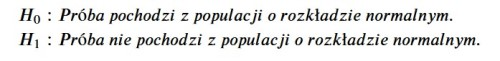

Dokumentacja języka Python mówi tylko tyle, że jeśli wynikowa p-wartość będzie mniejsza od 0,05 to odrzucamy hipotezę zerową i przyjmujemy alternatywną. Dlaczego mamy pewność że sprawdzając tylko jedną wartość jesteśmy pewni wyniku?

Zaimportujmy potrzebne metody do testów, czyli .shapiro oraz .normaltest z modułu scipy.stats. Podstawowe zbiory danych (2) oraz (3) pozostają bez zmian.

In [25]:
from scipy import stats


#### Test Shapiro

In [26]:
print('Wyniki testu Shapiro dla: ')
print('Długość w kraju:    %s - statystyka, %s - p-wartość' % (round(stats.shapiro(Y)[0],3), round(stats.shapiro(Y)[1], 3)))
print('Długość całkowita:  %s - statystyka, %s - p-wartość' % (round(stats.shapiro(X)[0],3), round(stats.shapiro(X)[1], 3)))


Wyniki testu Shapiro dla: 
Długość w kraju:    0.971 - statystyka, 0.897 - p-wartość
Długość całkowita:  0.785 - statystyka, 0.006 - p-wartość


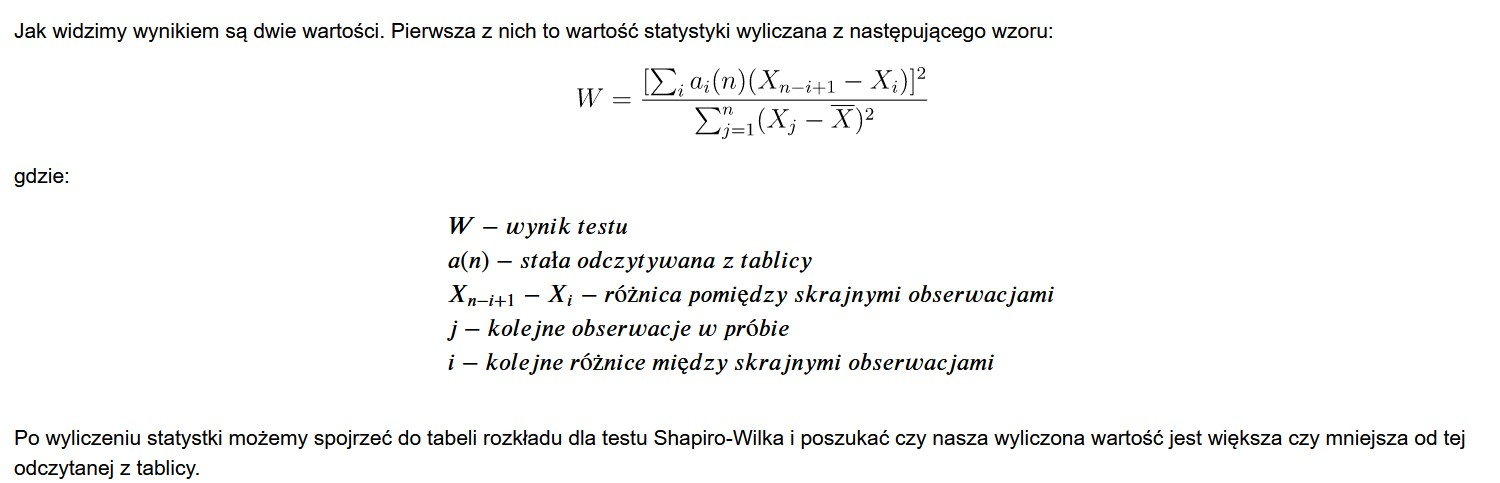

Python robi to wszystko za nas i podaje nam wynik na tacy jako p-wartość. Jeśli jest ona większa od 0,05 to nie mamy podstaw do odrzucenia hipotezy zerowej. Tak jest w przypadku cechy "Długość w kraju" (3). Natomiast hipotezę zerową odrzucamy dla cechy "Długość całkowita" (2). Innymi słowy dane dla długości w kraju mają rozkład normalny, a dla długości całkowitej nie.

#### Test D'Agostino-Pearsona

Nie powinno stosować się tego testu dla zbiorów danych mniejszych niż 20.

W tym przypadku nie ma to znaczenia ponieważ wyniki wyglądają bardzo podobnie jak wyżej, cały schemat tego testu jest analogiczny, stosowane są jedynie inne wzory. Możemy wyciągnąć dla tego testu identyczne wnioski. "Długość w kraju" ma rozkład normalny "Długość całkowita" nie ma rozkładu normalnego.


In [28]:
print('Wyniki testu D’Agostino-Pearsona dla: ')
print('Długość w kraju:    %s - statystyka, %s - p-wartość' % (round(stats.normaltest(Y)[0],3), round(stats.normaltest(Y)[1], 3)))
print('Długość całkowita:  %s - statystyka, %s - p-wartość' % (round(stats.normaltest(X)[0],3), round(stats.normaltest(X)[1], 4)))


Wyniki testu D’Agostino-Pearsona dla: 
Długość w kraju:    0.244 - statystyka, 0.885 - p-wartość
Długość całkowita:  15.942 - statystyka, 0.0003 - p-wartość


#### Estymacja parametrów rozkładu normalnego

Możemy to zrobić dla cechy "Długość w kraju" (3), ponieważ te dane posiadają rozkład normalny. Wzory na znalezienie parametrów uzyskujemy metodą największej wiarogodności. Ponadto narysujmy wykres dla tych danych.

$$\widehat{\mu} = \frac{1}{N}\sum_{i=1}^Nx_i,$$
$$\widehat{\sigma}^2 = \frac{1}{N}\sum_{i=1}^N(x_i-\mu)^2,$$

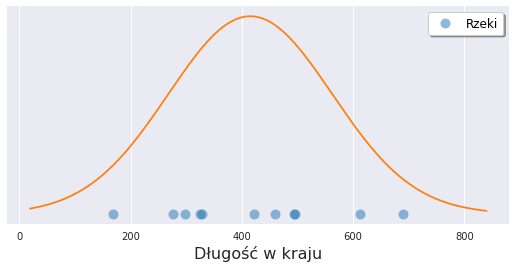

Średnia arytmetyczna:   415.09
Wariancja:              23871
Odchylenie standardowe: 154.5


In [29]:
from statistics import variance
from math import sqrt

def rozklad_norm(parametry, x):
    mu, sigma = parametry
    return np.exp(-(x-mu)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

mu_rzeki_dl_k, sigma_rzeki_dl_k = Y.mean(), Y.std()

os_x = np.linspace(Y.min()-150, Y.max()+150, num=300)

os_y_rzeki_dl_k = rozklad_norm([mu_rzeki_dl_k, sigma_rzeki_dl_k], os_x)

with plt.style.context('seaborn'):  
    plt.figure(figsize=(9,4))
    plt.plot(Y, np.zeros_like(X), 'o', 
             markersize=10, alpha=0.5, markerfacecolor='tab:blue', markeredgecolor='tab:green', 
             label='Rzeki')
    plt.plot(os_x, 25*os_y_rzeki_dl_k, color='tab:orange')
    plt.xlabel('Długość w kraju', fontsize=16)
    plt.yticks([])
plt.legend(shadow=True, fontsize=12)
plt.show()

print('Średnia arytmetyczna:   %s' % round(Y.mean(),2))
print('Wariancja:              %s' % variance(Y))
print('Odchylenie standardowe: %s' % round(sqrt(variance(Y)),2))


#### Wizualizacja danych i ich modelu w postaci estymatora Parzena dla trzech wybranych szerokości okna h.

Druga cecha czyli "Długość całkowita" (2) nie ma rozkładu normalnego, dlatego posłużymy się estymatorem Parzena dla trzech różnych wartości okna h. Niestety, ponieważ kilka rzek ma długości całkowite zbliżone do siebie nie będą one zbyt widoczne na wykresie. Dlatego najlepszym sposobem na przedstawinie ich będzie ustandaryzowanie wartości.

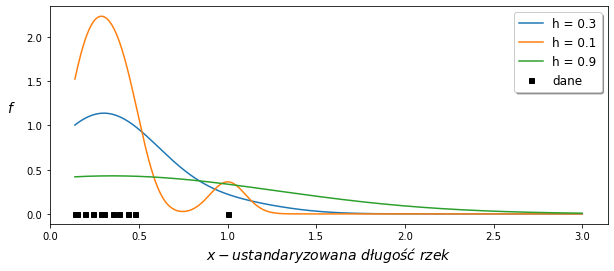

In [30]:
maximum_length = max(X)
X = X/maximum_length

def K(x):
  return np.exp(-x**2/2)/np.sqrt(2*np.pi)

os_x = np.linspace(X.min(), X.max()+2, num=1000)

H = [0.3, 0.1, 0.9]
N = X.size

plt.figure(figsize=(10,4))
for h in H:
  suma = 0
  for nr, pomiar in enumerate(X):
    suma += K((os_x-pomiar)/h)
  os_y = suma/(h*N)
  plt.plot(os_x, os_y, label=f'h = {h}')
  

plt.plot(X, np.zeros_like(X) , 's', markersize=5, color='black', label='dane')
plt.xlabel('$x - ustandaryzowana \\ długość \\ rzek$', fontsize=14)
plt.ylabel('$f$', fontsize=14, rotation='horizontal', labelpad=15)
plt.legend(fontsize=12, shadow=True)
plt.show()

Ostatnim zadaniem, które mamy do wykonania jest użycie optymalizatora do rozwiązania jakiegoś problemu. 

### 4. Zastosowanie optymalizatora do dopasowania modelu/rozkladu do danych rzeczywistych

Zadanie polega na znalezieniu optymalnych parametrów a oraz b we wzorze Y = aX + b, zbiory X (2) oraz Y (3) pozostają bez zmian. Tym razem nie wolno nam użyć do obliczeń wcześniejszych wzorów.

Przeprowadźmy trzy eksperymenty wybierając losowo punkt startowy poszukiwania optimum. Zaimportujmy jeszcze potrzebne do tego celu biblioteki z implementacją metody Neldera-Meada.

In [31]:
from scipy import optimize

Potrzebujemy jeszcze kilku założeń żeby rozpocząć eksperymenty. Argumenty a, b mają być wyliczane jako minimum funkcji błędu średniokwadratowego. Do liczenia błędu stosujemy niezmiennie wzór (4).

Ponadto zdefiniujmy stałe oraz funkcje do rysowania:

In [32]:
# ilość danych
DATASIZE = X.size

# funkcja licząca błąd
def count_error(arguments):
    a, b = arguments
    error = 0
    for i in range(0, DATASIZE):
        error = error + ( ( Y[i] - ( a * X[i] + b ) ) ) ** 2
    
    return error / DATASIZE

# rysowanie w 2D
def pokaz_2D(Fcelu, x_historia, zakres):
  x_pocz, x_opt = x_historia[0], x_historia[-1]
  os_x1 = np.linspace(zakres[0], zakres[1], num=100)
  os_x2 = np.linspace(zakres[2], zakres[3], num=100)
  siatka_X1, siatka_X2 = np.meshgrid(os_x1, os_x2)
  macierz_Z = Fcelu([siatka_X1, siatka_X2])

  fig, ax = plt.subplots(figsize=(8,8))
  cplot = ax.contourf(siatka_X1, siatka_X2, macierz_Z, 10, cmap='Spectral_r', alpha=1)
  clines = ax.contour(siatka_X1, siatka_X2, macierz_Z, 10, colors='black')
  for punkt in x_historia:
      ax.plot(punkt[0], punkt[1], 'o', 
              color='white', markeredgecolor='black', markersize=5, alpha=0.7)
  ax.plot(x_pocz[0], x_pocz[1], 'd', 
          color='gray', markeredgecolor='black', markersize=10, alpha=0.7)    
  ax.plot(x_opt[0], x_opt[1], 'h', 
          color='white', markeredgecolor='black', markersize=15)
  ax.set_aspect('equal')
  ax.set_xlabel(r'$x_1$', fontsize=16)
  ax.set_ylabel(r'$x_2$', fontsize=16)
  ax.clabel(clines)
  fig.colorbar(cplot)
  return fig, ax

# rysowanie w 3D
def pokaz_3D(Fcelu, zakres):
  os_x1 = np.linspace(zakres[0], zakres[1], 50)
  os_x2 = np.linspace(zakres[2], zakres[3], 50)
  siatka_X1, siatka_X2 = np.meshgrid(os_x1, os_x2)

  fig, ax = plt.subplots(figsize=(7,7), subplot_kw={'projection':'3d'})
  ax.plot_surface(siatka_X1, siatka_X2, Fcelu([siatka_X1, siatka_X2]), cmap='Spectral_r')
  ax.set_xlabel('$x_1$', fontsize=14)
  ax.set_ylabel('$x_2$', fontsize=14)
  ax.set_zlabel('$F$', fontsize=14)
  plt.show()

# funkcja pomocnicza
def model (parametry, x):
    a, b = parametry
    return a * x + b


Napiszmy pojedynczą metodę, która będzie przeprowadzać eksperyment, korzystającą z powyższego kodu. Pomoże to uniknąć pisania tego samego kilka razy. 

In [33]:
def run_experiment(start, jump):
    # ustalamy punkt startowy
    x_zero = np.random.normal(loc=start, scale=jump, size=2)        
    print('Punkt startowy : ' + str(round(x_zero[0], 4)) + ' ' + str(round(x_zero[1], 4)))  

    # szukamy minimum funkcji błędu i zapamiętujemy punkty żeby przedstawić je na wykresie
    x_opt, x_history = optimize.fmin(
        count_error, 
        x_zero, 
        disp=False,
        retall=True
    )

    print('a = %s' % round(x_opt[0], 4))
    print('b = %s' % round(x_opt[1], 4))
    print('Wartość błędu dla tak wyliczonych wartości a oraz b wynosi %s' % round(count_error(x_opt), 2))
    
    # rysujemy wykresy 2D oraz 3D
    m = x_zero.max() if x_zero.max() != 0 else 1
    zakres = [-10 * m, 10 * m, 10 * m, -10 * m]
    pokaz_2D(count_error, x_history, zakres)
    plt.show()
    pokaz_3D(count_error, zakres)
    
    # rysujemy linię na tle punktów
    X_test = np.linspace(start = X.min(), stop = X.max(), num = 300)
    Y_pred = model(parametry = [x_opt[0], x_opt[1]], x = X_test)
    plt.scatter(X,Y)
    plt.plot(X_test, Y_pred, color = 'tab:orange')
    plt.xlabel('x - Długość całkowita', fontsize = 14)
    plt.ylabel('y - Długość w kraju', fontsize = 14)
    plt.title('Model liniowy - szukanie minimalnego błędu', size = 20)
    plt.show()

#### Eksperyment 1

Punkt startowy : 105.9075 100.3464
a = 355.9314
b = 286.7474
Wartość błędu dla tak wyliczonych wartości a oraz b wynosi 15104.65


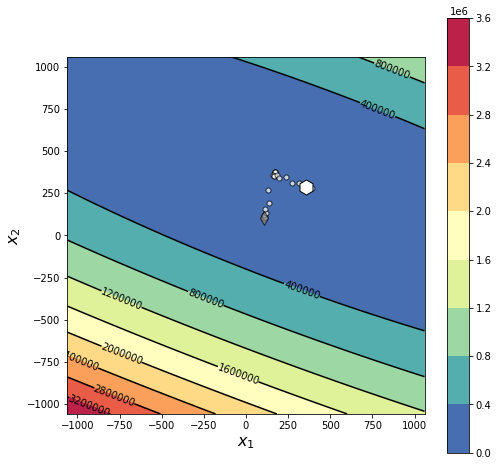

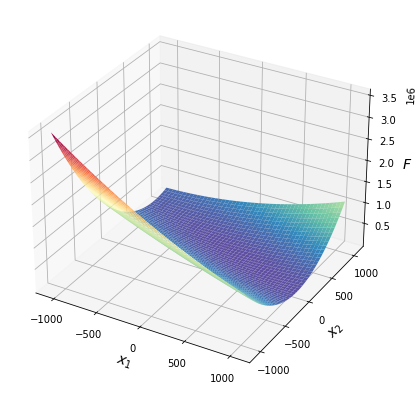

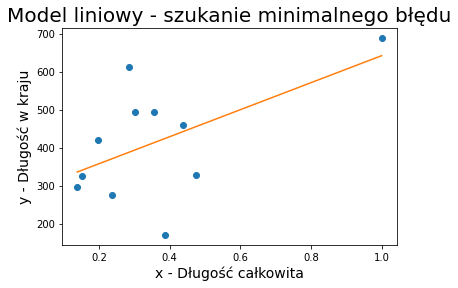

In [34]:
run_experiment(100, 5)

#### Eksperyment 2

Punkt startowy : 23.5129 54.9594
a = 355.9313
b = 286.7475
Wartość błędu dla tak wyliczonych wartości a oraz b wynosi 15104.65


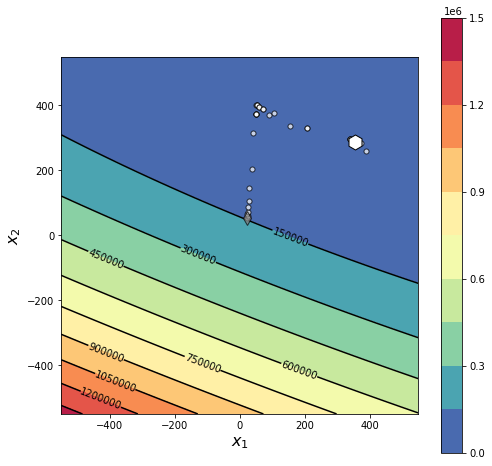

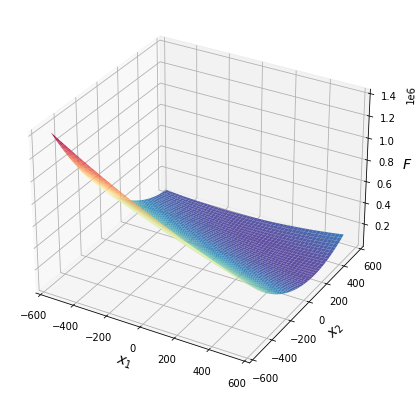

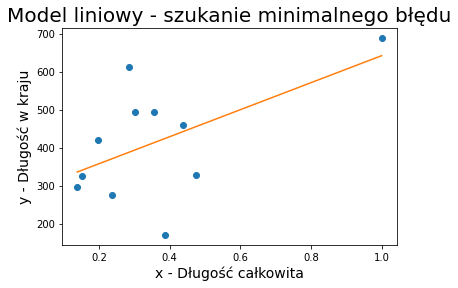

In [35]:
run_experiment(40, 10)

Punkt startowy : 208.4602 210.853
a = 355.9314
b = 286.7474
Wartość błędu dla tak wyliczonych wartości a oraz b wynosi 15104.65


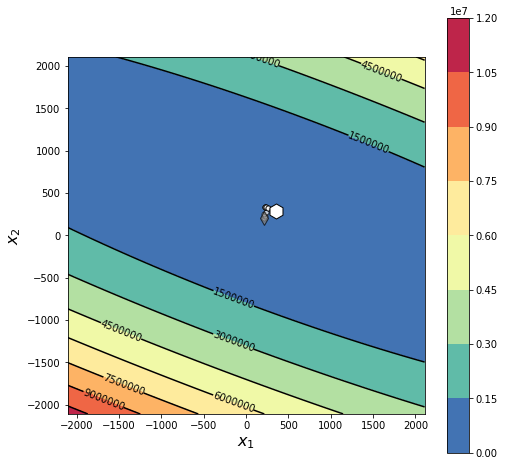

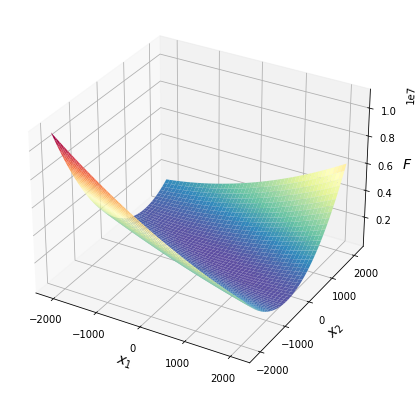

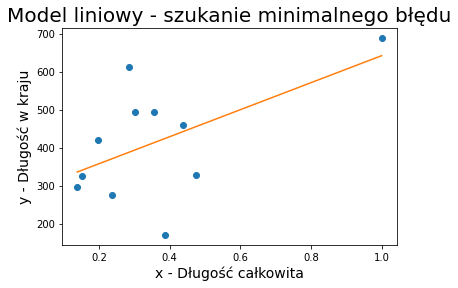

In [36]:
run_experiment(200, 41)

#### Wnioski

Każdy z trzech eksperymentów daje bardzo podobny wynik, parametr a wyszedł w każdym eksperymencie taki sam, natomiast parametr b różni się dopiero na 4 miejscu po przecinku. Oznacza to że dla danych rzek funkcja błędu ma jedno optimum globalne, do którego dąży metoda Neldera-Meada. Nie ma w tym wypadku większego znaczenia w jakim punkcie zaczniemy, ponieważ danych jest na tyle mało, że po kilku iteracjach metoda znajdzie się w pobliżu szukanego minimum. Ponadto wykres 3D przedstawia tę funkcję jako paraboloidę, co tylko potwierdza powyższe wnioski.

## Rozdział 5: Wnioski

W sprawozdaniu przedstawiłem główne metody operacji na danych, od momentu ich pobrania, aż do szukania rozkładu, ćwiczenia modelu czy korzystania z optymalizatora. Wydawać by się mogło, że dane które wybrałem nie będą kompletnie pasować do pokazania działania powyższych metod obliczeń oraz rysowania wykresów. Okazuje się, że jest odwrotnie, udało się nawet znaleźć dla jednego zbioru danych rozkład normalny. Jest to bardzo pozytywne zaskoczenie, sam byłem na początku sceptyczny co do wyboru długości rzek, a jak widać był to świetny wybór.